# Blocks Lead/Lag

In [149]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import intersect1d
from datetime import datetime
from pyathena import connect

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# add ethereum to python path (only do this once)
import sys
sys.path.insert(0, "/home/ec2-user/SageMaker/ethereum")

In [150]:
from ethereum import (
    timestamp_to_datetime,
    EthereumData
)
from utils import (
    latest,
    lead_lag,
    add_latest_avail_block,
    lagged_block_data
)

In [151]:
conn = connect(
    s3_staging_dir='s3://sagemaker-w210-eth/raw_data/August/',
    region_name='us-west-2'
)

In [152]:
conn.close()

In [53]:
cols = [
    'number', 'difficulty', 'total_difficulty', 'size', 'gas_limit', 
    'gas_used', 'timestamp', 'transaction_count', 'base_fee_per_gas'
]

blocks = pd.read_sql(f"SELECT {', '.join(cols)} FROM ethereumetl.blocks", conn)
blocks.shape

In [153]:
blocks.head()

,number,difficulty,total_difficulty,size,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas
0,13021551.0,None,None,163905.0,29970677.0,29970293.0,1.628921e+09,290.0,2.608603e+10
1,13021509.0,None,None,39184.0,30028810.0,9533024.0,1.628921e+09,222.0,4.039236e+10
2,13021552.0,None,None,18510.0,29999944.0,3848065.0,1.628921e+09,50.0,2.934670e+10
3,13021510.0,None,None,15740.0,29999486.0,2950586.0,1.628921e+09,52.0,3.854909e+10
4,13021553.0,None,None,116658.0,30000000.0,29992624.0,1.628921e+09,476.0,2.661943e+10


In [66]:
data_lags = [1] + [i * 10 for i in range(1, 7)]
block_lookback_lags = [i * 20 for i in range(6)]

In [68]:
pit = {
    k : get_pit_blocks(blocks.loc[:1000,], lag=k) for k in data_lags
}

In [69]:
pit_data = {
    k : lagged_block_data(blocks.loc[:1000,], v) for k, v in pit.items()
}

In [142]:
pit_data[60]

,difficulty_lagged,total_difficulty_lagged,size_lagged,gas_limit_lagged,gas_used_lagged,timestamp_lagged,transaction_count_lagged,base_fee_per_gas_lagged
number,,,,,,,,
12991647.0,None,None,NaN,NaN,NaN,NaN,NaN,NaN
12991648.0,None,None,NaN,NaN,NaN,NaN,NaN,NaN
12991649.0,None,None,NaN,NaN,NaN,NaN,NaN,NaN
12991650.0,None,None,NaN,NaN,NaN,NaN,NaN,NaN
12991651.0,None,None,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
13022459.0,None,None,131897.0,29999914.0,29979757.0,1.628934e+09,309.0,3.186493e+10
13022460.0,None,None,175529.0,29970705.0,29952910.0,1.628934e+09,427.0,2.915884e+10
13022461.0,None,None,175529.0,29970705.0,29952910.0,1.628934e+09,427.0,2.915884e+10


In [106]:
x_variable = 'base_feae_per_gas'

In [100]:
lead_lag_cols = [
    'base_fee_per_gas', 'size', 'gas_used', 'transaction_count' #'difficulty', 'total_difficulty', 
]

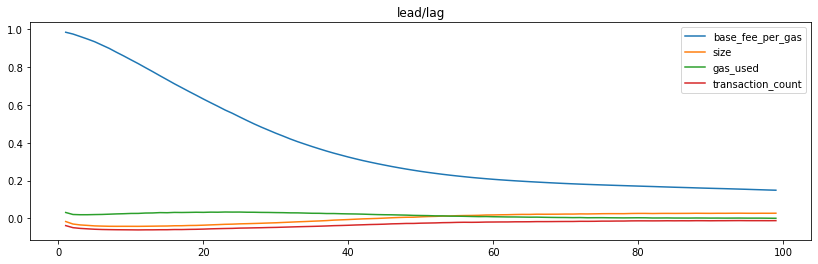

In [141]:
pd.DataFrame({
    k : lead_lag(
        blocks[x_variable], blocks[k], lags=range(1, 100), z_score=True
    ) for k in lead_lag_cols
}).plot(title='lead/lag', figsize=(14, 4));

In [118]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [128]:
x = pit_data[60][['base_fee_per_gas_lagged']].ewm(halflife=20).mean().dropna()
y = blocks.set_index('number')['base_fee_per_gas'][x.index]

In [129]:
reg = LinearRegression().fit(x, y)

In [131]:
reg.score(x, y)

0.4421607050126749

In [133]:
reg.coef_

array([0.8296486])

In [134]:
pred_y = reg.predict(x)

In [136]:
mean_squared_error(y, pred_y)

1.9842553316207297e+19

In [137]:
sample_results = pd.DataFrame({
    "pred" : pred_y,
    "actual" : y
}).sample(5000)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
plt.scatter(y, sample_results['effective_gas_price'])
plt.title('Predicted vs Realized Gas Prices');
